# Detect cancer
* Correlation matrix
* Oversampling ADASYN
* PCA feature importance

In [275]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
matplotlib.get_backend()
%matplotlib inline
plt.style.use('seaborn')


from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

In [270]:
def score_cross_val(scores):
    
    # Scores sur cross validation
    scores = pd.DataFrame(scores)
    scores.plot()

    plt.xlabel('CV')
    plt.ylabel('Score')
    plt.title("Scores sur le train de chaque cross validation")

    plt.axis()
    plt.legend("scores", loc='upper center')
    plt.show()

def plot_roc_auc_curve(model, X_test, y_test):
    
    # overall accuracy
    acc = model.score(X_test, y_test)

    # get roc/auc info
    # predict_proba is the porbability that X takes a class
    Y_score = model.predict_proba(X_test)[:, 1] 
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test, Y_score)

    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))
    plt.legend(loc="lower right", shadow=True, fancybox=True)
    plt.title('ROC curve and AUC')
    plt.show()

def plot_confusion_matrix(y_test, y_pred):
    
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

def plot_corr_matrix(df):
    
    data_correlation = df[list(df.columns)].corr()
    mask = np.array(data_correlation)
    mask[np.tril_indices_from(mask)] = False
    fig = plt.subplots(figsize=(30,20))
    sns.heatmap(data_correlation, mask=mask, vmax=1, square=True, annot=True);

In [276]:
df = pd.read_csv('./data.csv')

In [277]:
names = ['id', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst'] 

dx = ['Benign', 'Malignant']


# Setting 'id_number' as our index
df.set_index(['id'], inplace = True) 
# Converted to binary to help later on with models and plots
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})
df = df.drop(['Unnamed: 32'], axis=1)

In [278]:
df.diagnosis.value_counts(normalize=True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

In [279]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [280]:
# Create 2 matrix
y = df['diagnosis']
X = df.loc[:, df.columns != 'diagnosis']

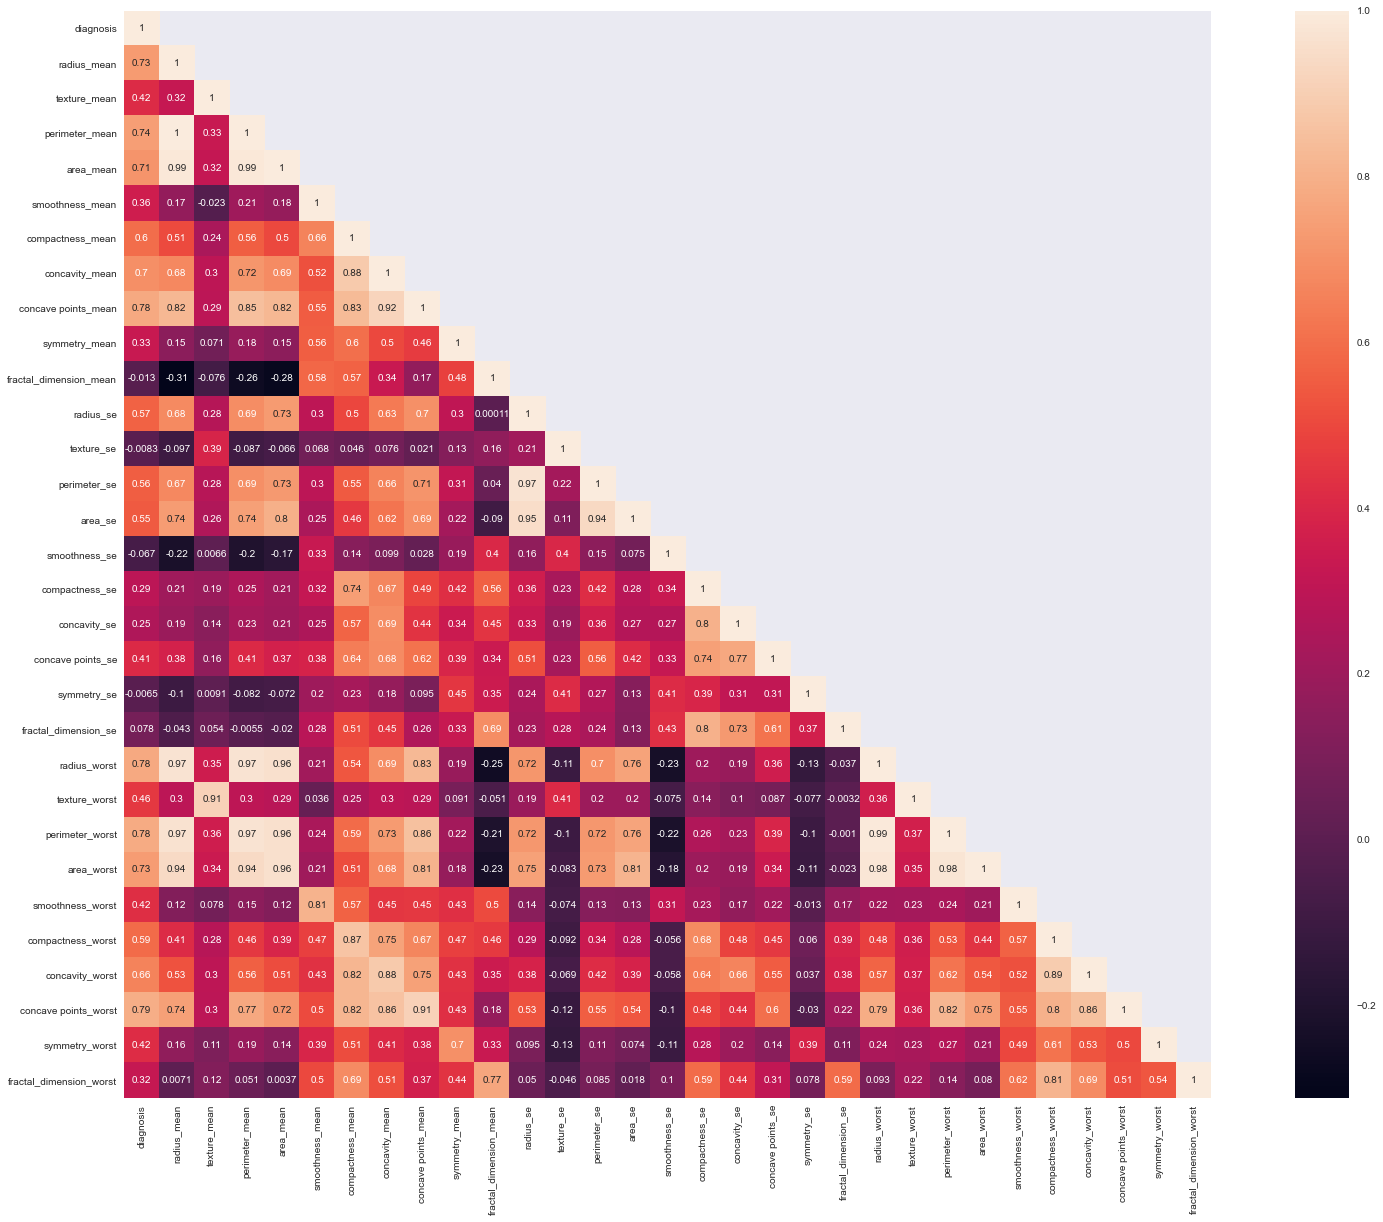

In [308]:
plot_corr_matrix(df)

In [282]:
columns = list(df.columns)
li = ['id', 'diagnosis']
for i in columns:
    if i in li:
        columns.remove(i)
df_grouped = df.groupby('diagnosis')[columns].mean()

In [283]:
df_grouped

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
0,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
1,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530


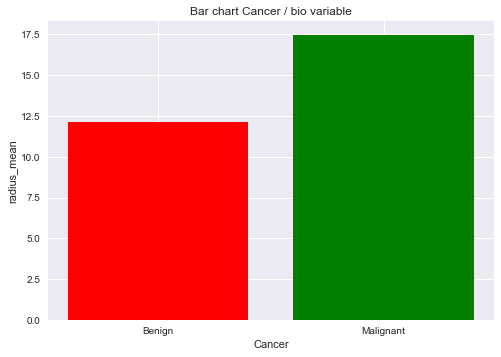

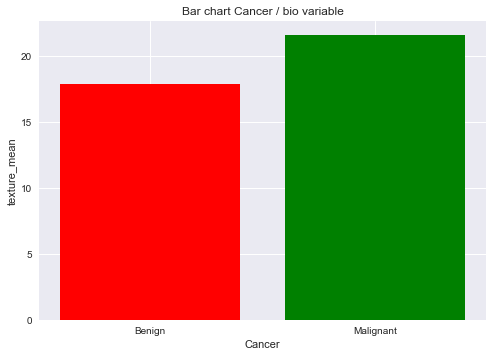

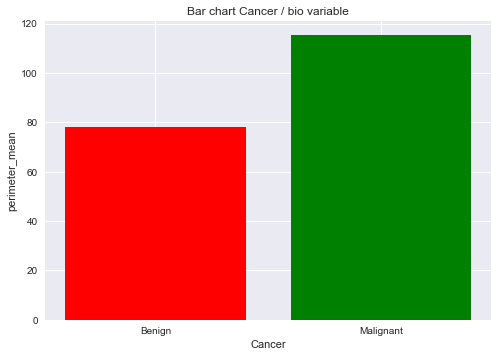

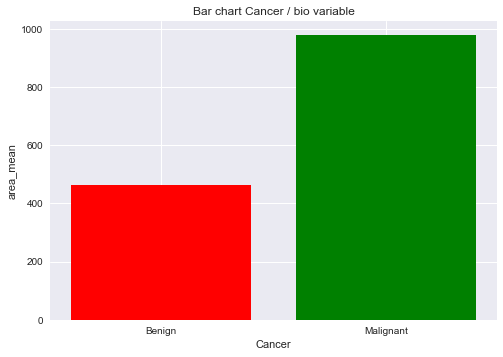

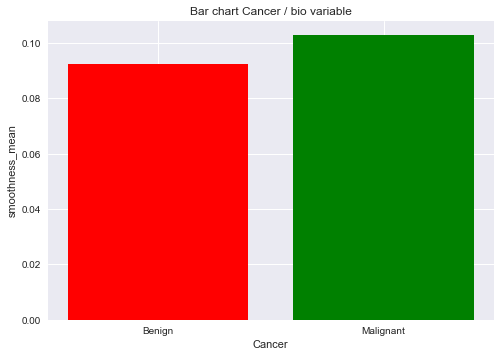

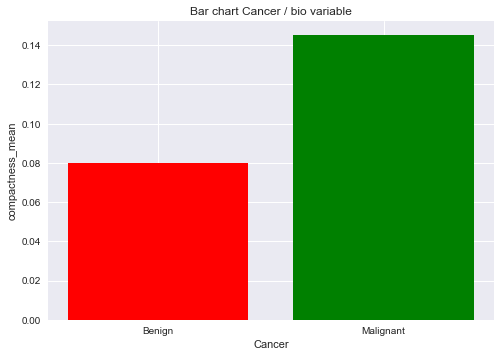

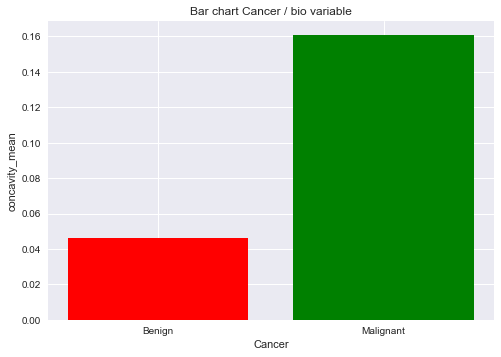

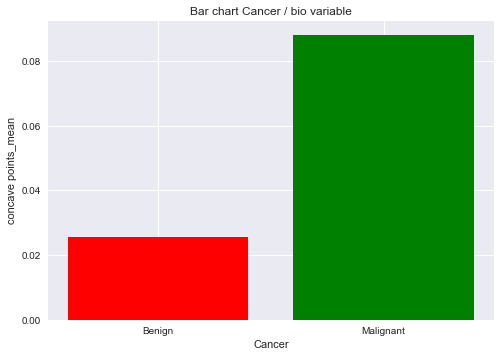

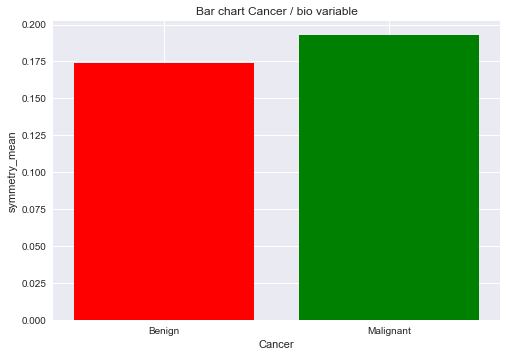

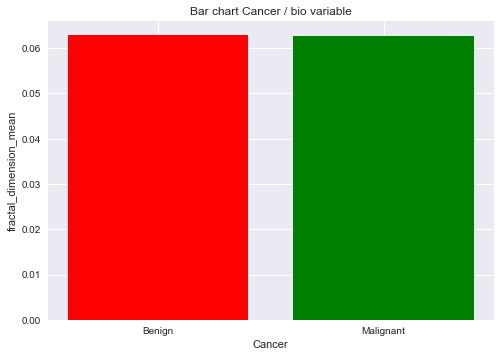

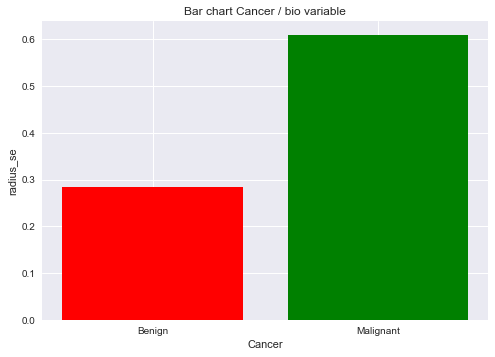

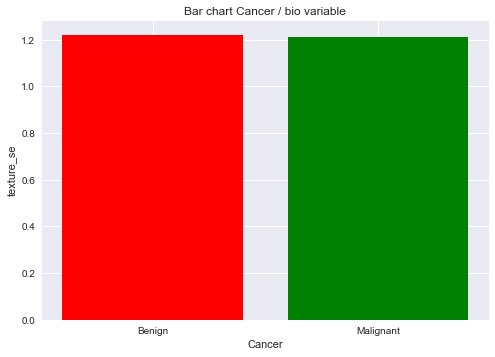

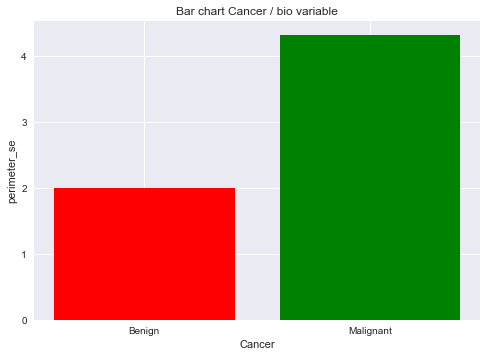

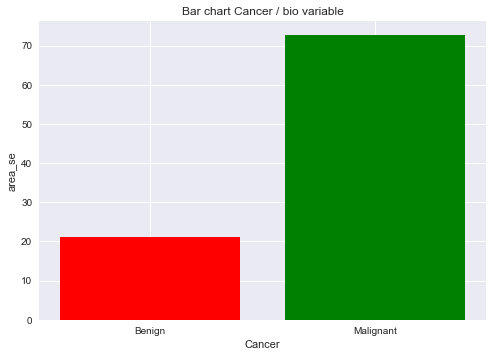

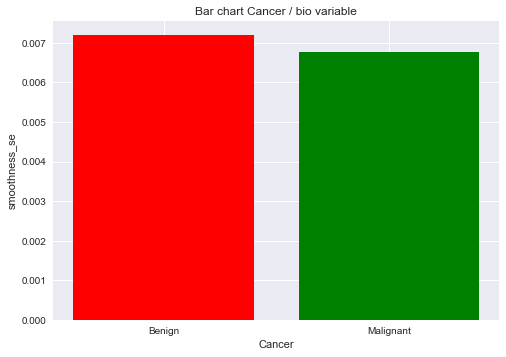

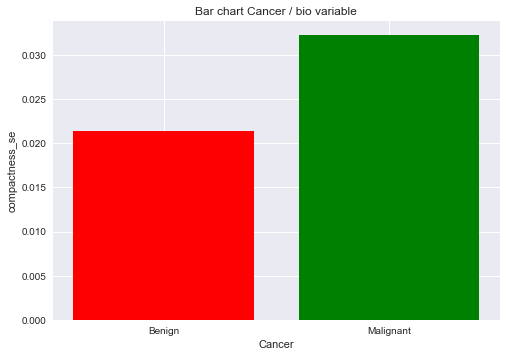

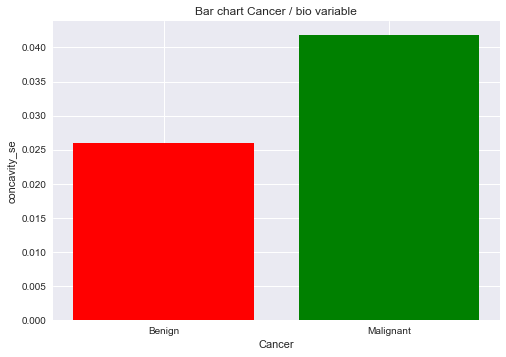

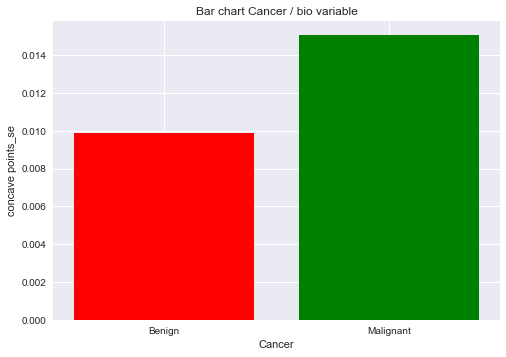

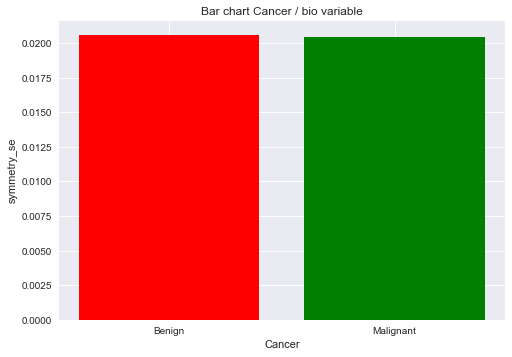

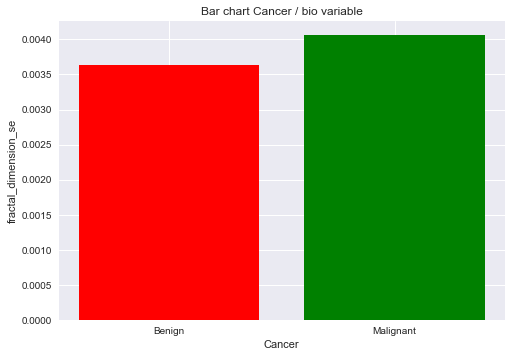

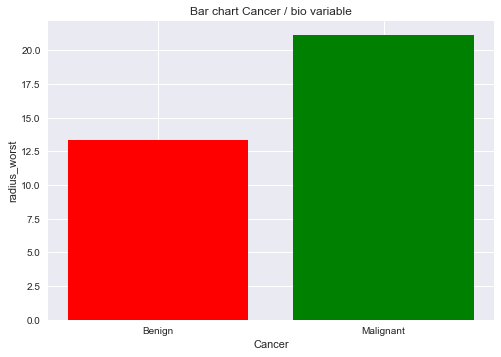

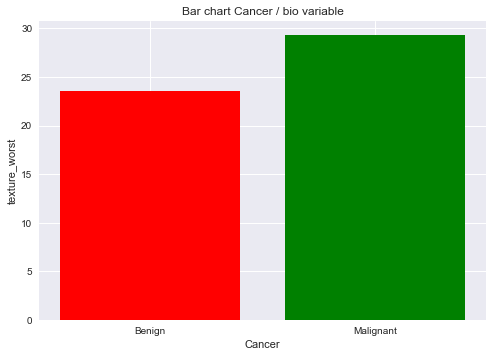

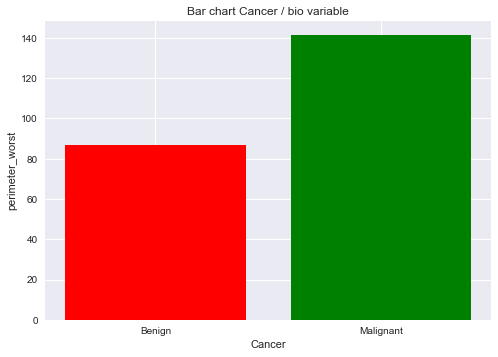

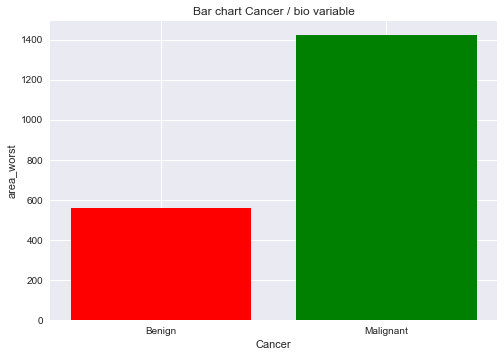

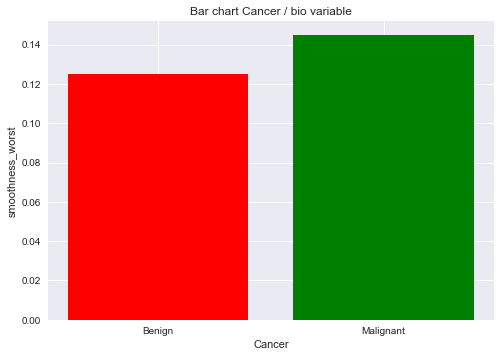

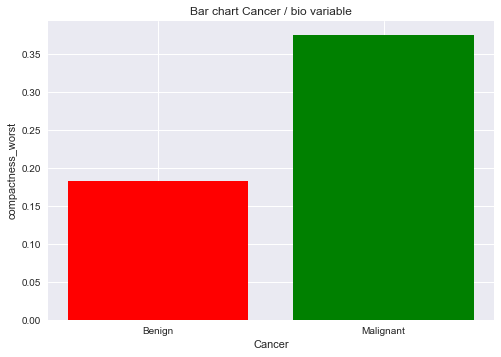

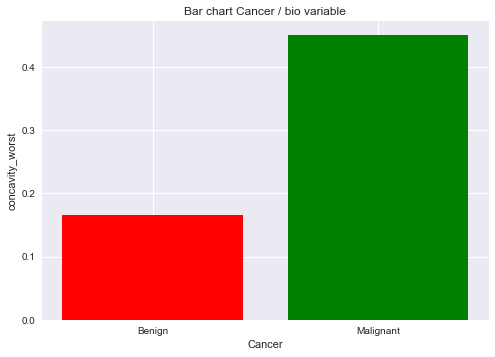

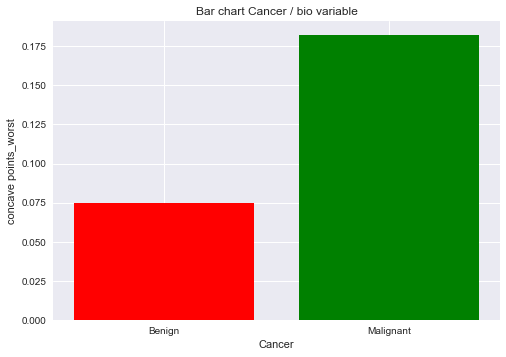

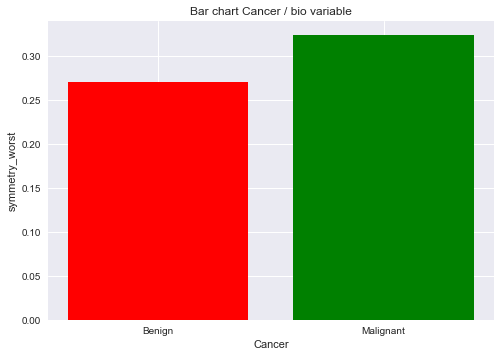

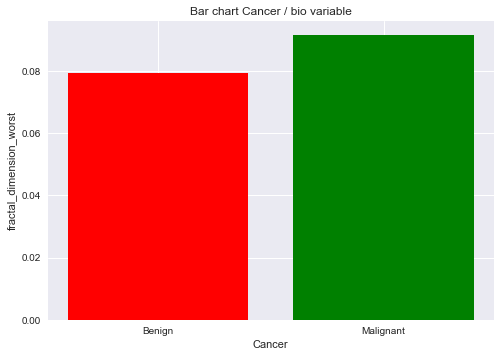

In [284]:
for i in df_grouped.columns:
    #print(df_grouped[i].values)
    # x-coordinates of left sides of bars
    left = [0, 1]

    # heights of bars
    height = df_grouped[i].values

    # labels for bars
    tick_label = ['Benign', 'Malignant']

    # plotting a bar chart
    plt.bar(left, height, tick_label=tick_label,
            width = 0.8, color = ['red', 'green'])

    # naming the x-axis
    plt.xlabel('Cancer')
    # naming the y-axis
    plt.ylabel(i)
    # plot title
    plt.title('Bar chart Cancer / bio variable')

    # function to show the plot
    plt.show()

### Plots
* 'concave points_mean' and 'concave points_worst' are highly correlated with diagnosis
* 'concavity_se' is not correlated with diagnosis

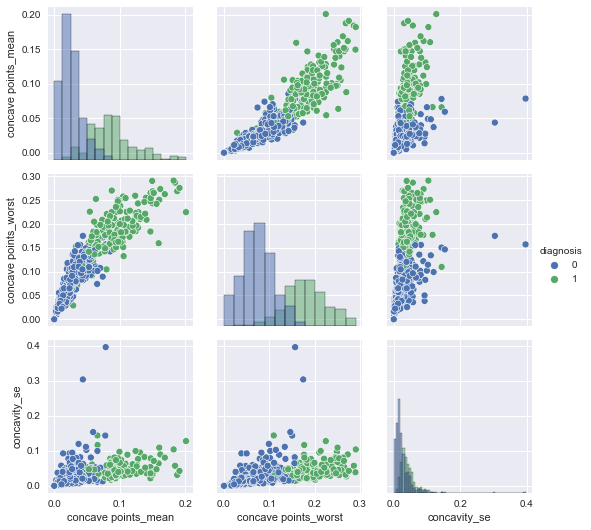

In [285]:
sub_x = df[['concave points_mean', 'concave points_worst', 'concavity_se', 'diagnosis']]
g = sns.PairGrid(sub_x, hue="diagnosis")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

In [286]:
numpy_array = X.to_numpy()

In [287]:
numpy_array.shape

(569, 30)

In [288]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN

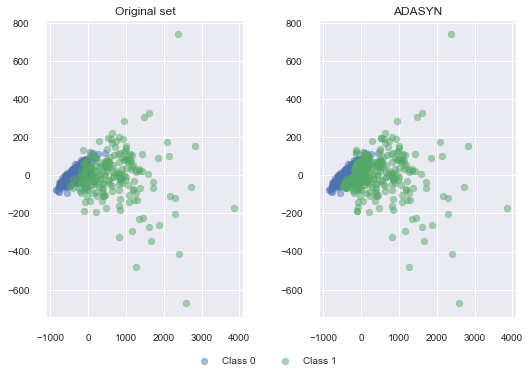

In [289]:
# Instanciate a PCA to reduce the dimensionality
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Over-sampling
ada = ADASYN()
X_resampled, y_resampled = ada.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)

f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=.5)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=.5)
ax2.set_title('ADASYN')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))


plt.figlegend((c0, c1), ('Class 0', 'Class 1'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

### New dimensions of dataset resampled

In [290]:
X_resampled

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.990000,10.380000,122.800000,1001.000000,0.118400,0.277600,0.300100,0.147100,0.241900,0.078710,...,25.380000,17.330000,184.600000,2019.000000,0.162200,0.665600,0.711900,0.265400,0.460100,0.118900
1,20.570000,17.770000,132.900000,1326.000000,0.084740,0.078640,0.086900,0.070170,0.181200,0.056670,...,24.990000,23.410000,158.800000,1956.000000,0.123800,0.186600,0.241600,0.186000,0.275000,0.089020
2,19.690000,21.250000,130.000000,1203.000000,0.109600,0.159900,0.197400,0.127900,0.206900,0.059990,...,23.570000,25.530000,152.500000,1709.000000,0.144400,0.424500,0.450400,0.243000,0.361300,0.087580
3,11.420000,20.380000,77.580000,386.100000,0.142500,0.283900,0.241400,0.105200,0.259700,0.097440,...,14.910000,26.500000,98.870000,567.700000,0.209800,0.866300,0.686900,0.257500,0.663800,0.173000
4,20.290000,14.340000,135.100000,1297.000000,0.100300,0.132800,0.198000,0.104300,0.180900,0.058830,...,22.540000,16.670000,152.200000,1575.000000,0.137400,0.205000,0.400000,0.162500,0.236400,0.076780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,14.050788,23.495046,93.068522,613.286044,0.109841,0.141072,0.141136,0.064410,0.209601,0.065934,...,15.640739,33.622107,105.128133,757.382099,0.158167,0.333364,0.381847,0.143945,0.316224,0.100458
711,14.014898,22.578345,93.689690,605.470783,0.108193,0.169208,0.177715,0.070300,0.199355,0.067851,...,15.167173,33.202349,106.425854,713.844193,0.150802,0.509128,0.551376,0.176166,0.312223,0.111661
712,14.078970,19.931498,92.460749,606.084381,0.103241,0.132313,0.124266,0.058888,0.200987,0.064172,...,15.504326,30.850105,104.346593,738.457181,0.141727,0.349572,0.442130,0.149805,0.313224,0.093942
713,15.223139,30.532766,103.405231,717.088331,0.104977,0.208416,0.254320,0.094171,0.212380,0.071511,...,17.514638,42.705513,128.556136,914.926760,0.142112,0.787842,1.162429,0.235348,0.407493,0.140453


In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set the random state for reproducibility
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### features importance

In [292]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': rf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

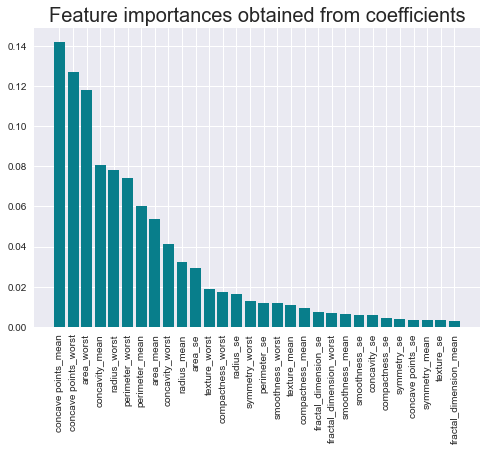

In [293]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### PCA for features importance

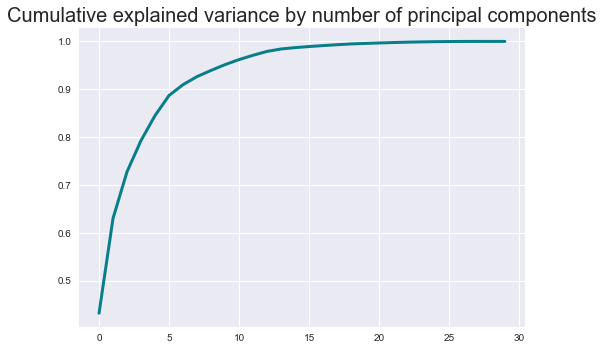

In [294]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

It means you can explain 90-ish% of the variance in your source dataset with the first five principal components. Again, refer to the from-scratch guide if you don’t know what this means.

You can now start dealing with PCA loadings. These are just coefficients of the linear combination of the original variables from which the principal components are constructed[2]. You can use loadings to find correlations between actual variables and principal components.

If there’s a strong correlation between the principal component and the original variable, it means this feature is important — to say with the simplest words.

Here’s the snippet for computing loading scores with Python:

In [295]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
radius_mean,0.781626,-0.580723,-0.016703,-0.057967,0.058744,0.035375,-0.125581,0.028554,-0.117446,0.034773,...,-0.001590,-0.024059,-0.010589,-0.020833,0.012580,-0.014169,0.003756,0.007485,0.006675,-0.007496
texture_mean,0.384967,-0.108653,0.109308,0.848158,-0.004710,-0.082695,0.022130,0.054137,0.162481,0.000343,...,0.023740,0.052606,-0.046789,0.000477,-0.017734,-0.002051,0.001014,-0.000002,-0.000358,-0.000014
perimeter_mean,0.814411,-0.537733,-0.017759,-0.060669,0.058994,0.030079,-0.116905,0.022759,-0.115283,0.021919,...,0.003999,-0.018476,-0.001618,-0.012516,0.004263,-0.014150,0.002531,0.000740,0.010569,0.007518
area_mean,0.791236,-0.571358,0.044957,-0.082122,0.015631,0.001484,-0.067536,0.058082,-0.113781,0.060858,...,0.014909,-0.007678,-0.011617,0.021791,0.015691,0.045180,-0.019042,-0.008268,-0.013073,0.000286
smoothness_mean,0.511556,0.439480,-0.216256,-0.181252,-0.494682,-0.296659,-0.103669,-0.200117,-0.032833,-0.129803,...,-0.002976,-0.021026,0.003756,0.009583,-0.004324,0.000519,-0.005081,0.000275,0.000042,0.000050


The first principal component is crucial. It’s just a single feature, but it explains over 60% of the variance in the dataset. As you can see from Image 5, the correlation coefficient between it and the mean radius feature is almost 0.8 — which is considered a strong positive correlation.

Let’s visualize the correlations between all of the input features and the first principal components. Here’s the entire code snippet (visualization included):


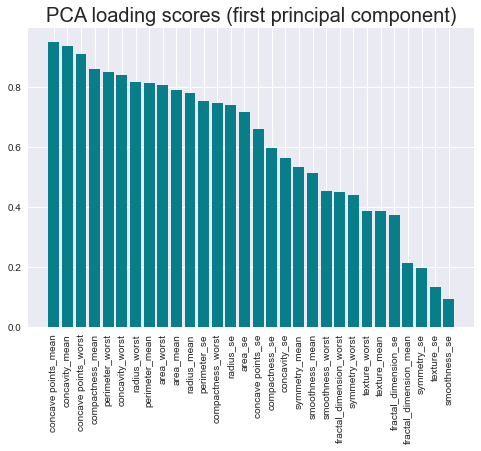

In [296]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [298]:
# Predict
y_pred = rf.predict(X_test)

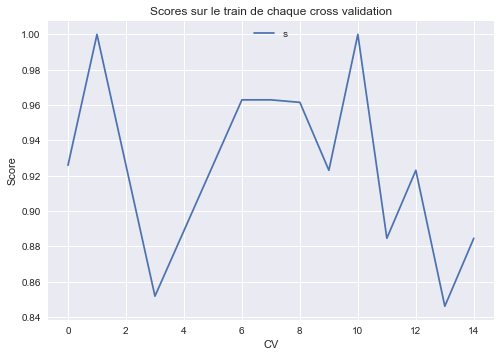

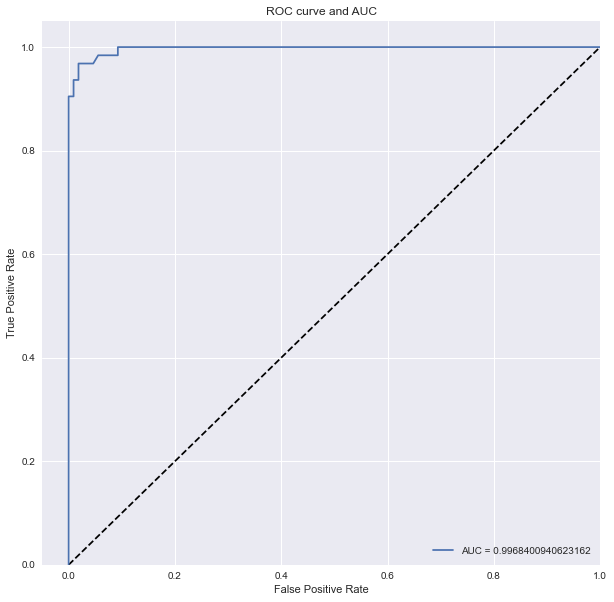

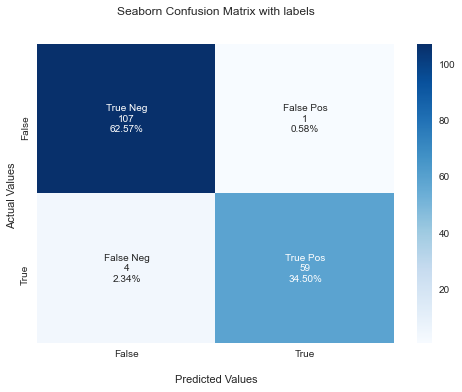

In [299]:
score_cross_val(scores)
plot_roc_auc_curve(rf, X_test, y_test)
plot_confusion_matrix(y_test, y_pred)

In [302]:
rf = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=6,
                            n_jobs=-1, random_state=3, verbose=0, 
                            class_weight='balanced')
rf.fit(X_train, y_train)
scores = cross_val_score(rf, X_train, y_train, cv=15)
y_pred = rf.predict(X_test)

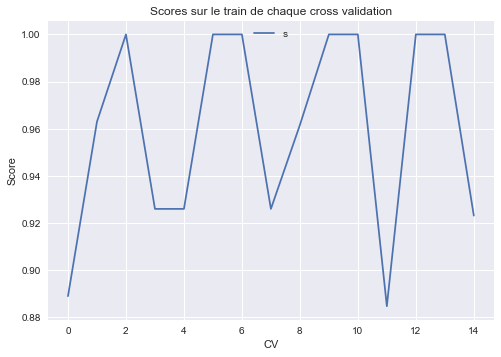

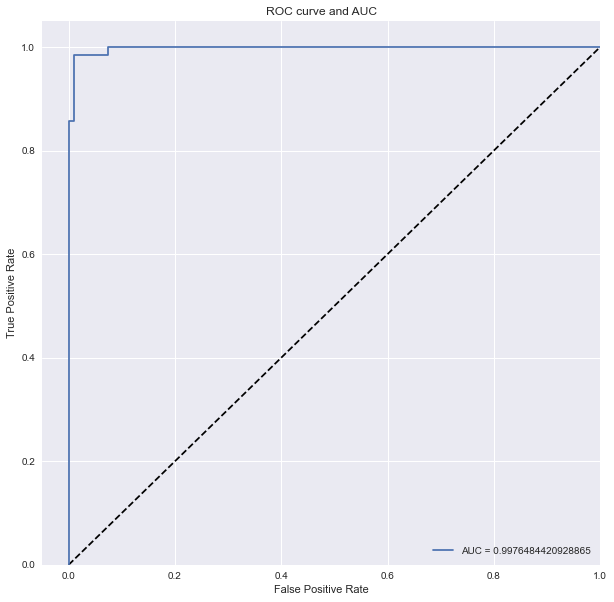

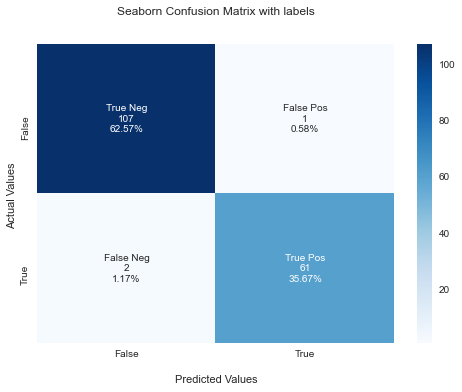

In [303]:
score_cross_val(scores)
plot_roc_auc_curve(rf, X_test, y_test)
plot_confusion_matrix(y_test, y_pred)

In [305]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', tol=0.001, fit_intercept=False, 
                        class_weight='balanced', random_state=1, 
                        verbose=0, warm_start=None, n_jobs=-1)
lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, cv=15)
y_pred = lr.predict(X_test)

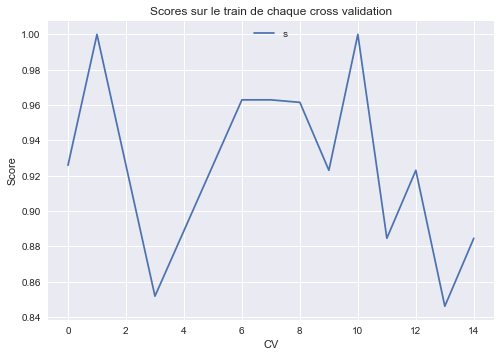

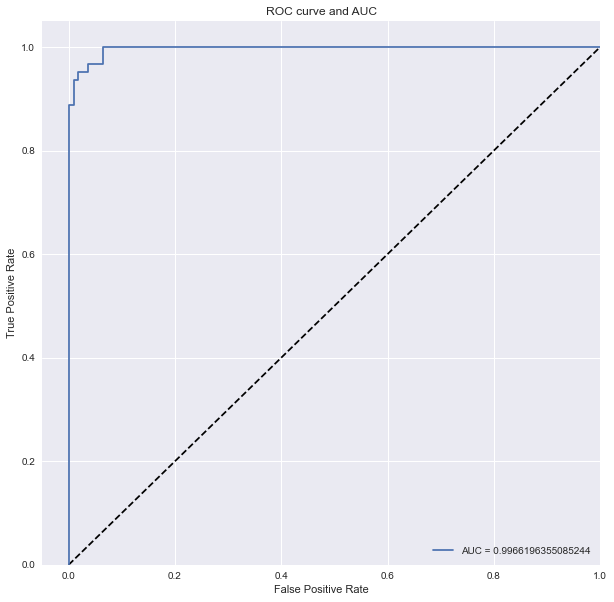

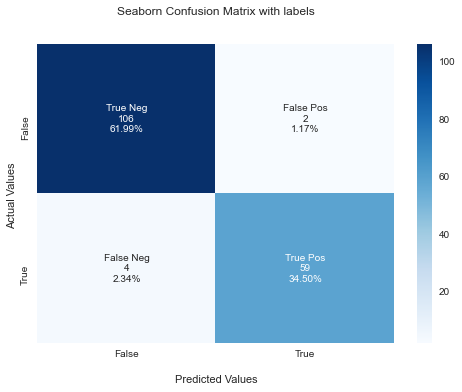

In [306]:
score_cross_val(scores)
plot_roc_auc_curve(lr, X_test, y_test)
plot_confusion_matrix(y_test, y_pred)

In [309]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

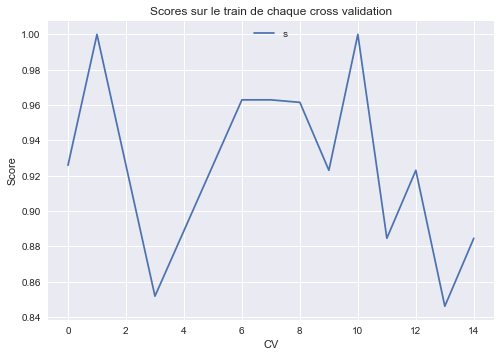

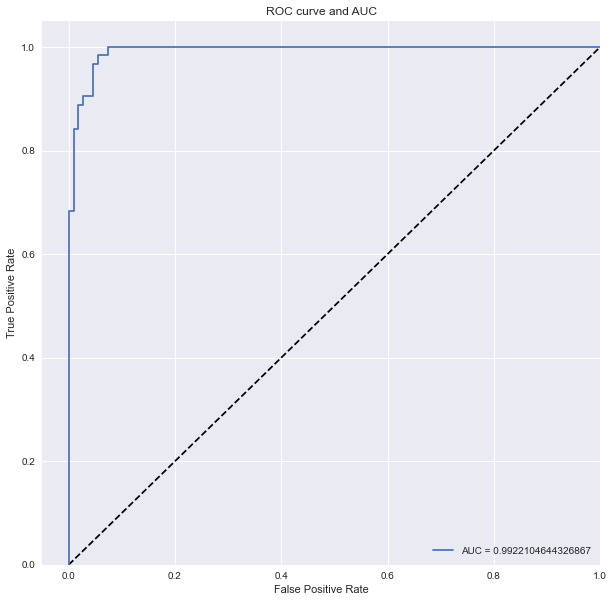

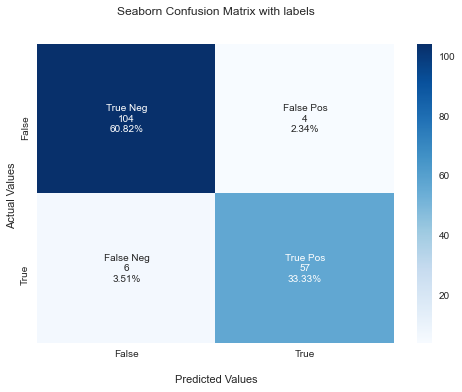

In [310]:
score_cross_val(scores)
plot_roc_auc_curve(gnb, X_test, y_test)
plot_confusion_matrix(y_test, y_pred)